# Classification with Decision Trees and Random Forests

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from classification_utils import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_blobs
import statistics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
import pickle

In [2]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)
data = data.join(pd.get_dummies(data["lang"]))
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std']


## Decision trees

In [3]:
param_grid = {
              'ccp_alpha': [0.0, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3, 4],
             }


dt = tree.DecisionTreeClassifier()

grid = GridSearchCV(
    dt,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=4
)


grid.fit(train_set, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)


Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.840 total time=   0.1s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.853 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.856 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.884 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.877 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_we

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.891 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.850 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.861 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.842 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.849 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.846 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.840 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.851 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.851 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_w

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=2, min_weight

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.891 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.845 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.859 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.845 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.849 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.844 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=4, min_samples_split=

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_w

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_w

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=4, min_samples_split=4, min_weight_

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_spl

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=4, min_samples_split=

[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=1, min_samples_split=3, min

[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=2, min_sample

[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=2, min_samples_split=

[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=3, min_samples_split=4, mi

[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, min_samples_leaf=4, min_sample

[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=1, min_sample

[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_spli

[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=2, mi

[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.898 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=3, min_sample

[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, min_samples_leaf=4, min_samples_spli

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.886 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.905 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.902 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.885 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.905 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.902 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, mi

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.885 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.905 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.902 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_sample

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_spl

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.896 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.886 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.905 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.902 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.885 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.905 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.902 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, mi

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.885 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.905 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.902 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=4, min_sample

[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samp

[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.869 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.886 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.878 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.866 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.878 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.887 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_le

[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.863 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.873 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=2, mi

[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=3, min_sam

[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.868 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.886 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.878 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.871 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.884 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.877 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_le

[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.870 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.884 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.877 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, min_samples_leaf=4, mi

[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.849 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.845 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=1, min_sampl

[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.883 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=2, min_sam

[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.877 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.891 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.858 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.842 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.851 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_lea

[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.842 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.848 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.846 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.680 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=3,

[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.852 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.844 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.860 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.879 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.890 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, min_samples_leaf=4, min_sampl

[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=1, min_samples_split=3,

[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=2, min_samples_split=2, mi

[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=2, min_weight_f

[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=3, min_samples_split=4, min_weight

[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, min_samples_leaf=4, min_samples_split=

[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=1, min_samples_split=2, min_w

[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=2, min_weight_

[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=2, min_samples_split=

[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.2;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=3, min_samples_split=3, min_w

[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, min_samples_leaf=4, min_samples_split=3, min_weight

In [4]:
dt = grid.best_estimator_
dt

DecisionTreeClassifier(ccp_alpha=0.001, min_weight_fraction_leaf=0.001)

In [5]:
train_pred = dt.predict(train_set)
test_pred = dt.predict(test_set)

In [6]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8972067039106145
Accuracy test set  0.8925571966406024
Precision train set  0.9112438314892902
Recall train set  0.8972067039106145
F1 score train set  0.8956222644775563
Support train set  (array([0.98969415, 0.84208441]), array([0.78881823, 0.9927587 ]), array([0.87791212, 0.91123499]), array([3774, 4281]))


In [7]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

        <=50       0.97      0.79      0.87      1618
         >50       0.84      0.98      0.91      1835

    accuracy                           0.89      3453
   macro avg       0.91      0.89      0.89      3453
weighted avg       0.90      0.89      0.89      3453



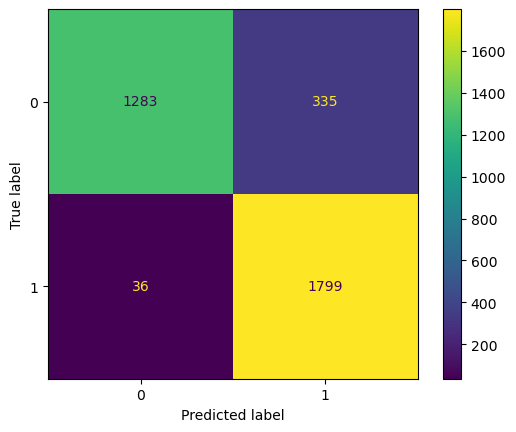

In [8]:
predictions = dt.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [9]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

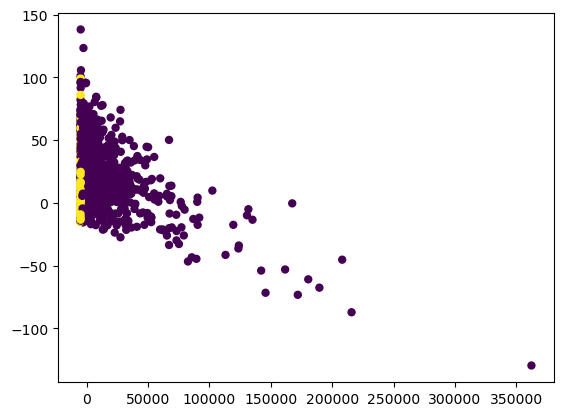

In [10]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

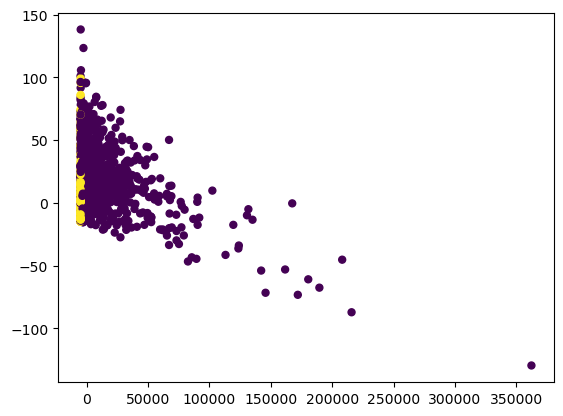

In [11]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save model

In [50]:
with open("models_checkpoints/decision_tree_lang.bin", "wb") as f:
    pickle.dump(dt, f)

FileNotFoundError: [Errno 2] No such file or directory: 'models_checkpoints/decision_tree_lang.bin'

### Removed "lang" attribute for classification

In [12]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)
data.drop(columns=['lang'])
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std']


In [13]:
param_grid = {
              'ccp_alpha': [0.0, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3, 4],
              'criterion': ['gini', 'entropy']
             }


dt = tree.DecisionTreeClassifier()

grid = GridSearchCV(
    dt,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=4
)


grid.fit(train_set, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)


Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.844 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.854 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.851 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_sampl

[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.847 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.851 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, 

[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.899 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.

[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.876 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.879 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.880 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_l

[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.899 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.876 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.879 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=

[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.850 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.848 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fractio

[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.846 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.837 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.851 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.839 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_spli

[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.883 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.852 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.847 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.847 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=1, min_samples_split=4,

[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.850 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.844 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.848 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.844 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.852 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=2, min_samples_split=

[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.880 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.883 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.849 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=2, mi

[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.883 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.846 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.852 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.845 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=3, min_samples_split=4,

[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.844 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.842 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.846 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.846 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0, criterion=entropy, min_samples_leaf=4, min_samples_split=

[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_le

[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction

[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_frac

[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fractio

[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fractio

[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fracti

[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_spli

[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=1, min_samples_split=4,

[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=2, min_samples_split=

[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=2, mi

[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=3, min_samples_split=4,

[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.1, criterion=entropy, min_samples_leaf=4, min_samples_split=

[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fr

[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fractio

[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fra

[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fractio

[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_

[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fra

[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples

[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=1, min_samples_spli

[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=2, min_samples_sp

[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_

[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=3, min_samples_spli

[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.05, criterion=entropy, min_samples_leaf=4, min_samples_s

[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fra

[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_

[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weig

[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_

[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fra

[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fractio

[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_sp

[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=1, min_samples_split=4,

[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_w

[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min

[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=3, min_samples_split=4,

[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.01, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_

[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_

[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_we

[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_

[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_

[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_wei

[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_

[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_sam

[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=1, min_samples_s

[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=2, min_samples_split=3

[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split

[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=3, min_samples_s

[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.895 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.005, criterion=entropy, min_samples_leaf=4, min_samples_split=

[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.899 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.893 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_

[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.901 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.903 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.895 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.903 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_

[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.895 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.903 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.895 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.903 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=2, min_samples_split=3, m

[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.901 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.903 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.895 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.903 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_

[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.893 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.899 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.895 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.901 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.903 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_wei

[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.894 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.899 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.893 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.895 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_

[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.892 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.875 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.892 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.882 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_sam

[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.899 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=1, min_samples_s

[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.874 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.873 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.890 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=2, min_samples_split=3

[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.888 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split

[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.899 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=3, min_samples_s

[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.877 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.877 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.890 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.001, criterion=entropy, min_samples_leaf=4, min_samples_split=3

[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_wei

[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.880 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.876 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_f

[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_wei

[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.872 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.872 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_f

[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.899 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.887 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.887 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_

[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.880 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.880 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.874 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.869 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.890 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=gini, min_samples_leaf=4, min_samples_split=

[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.880 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.863 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.851 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, mi

[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.863 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.851 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.846 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=1,

[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.859 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.844 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.840 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=

[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.880 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.863 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, mi

[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.863 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.859 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.846 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=3,

[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.860 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.850 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.852 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0005, criterion=entropy, min_samples_leaf=

[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.899 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.876 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.879 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.887 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=2, m

[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.887 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.858 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=1, min_samples_split=4

[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.887 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.852 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.851 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.853 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=2, min_samples_split=3

[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.853 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.852 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_spl

[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.855 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.856 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.853 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=3, min_samples_split=

[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.876 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.879 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.887 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=gini, min_samples_leaf=4, min_samples_split=3, 

[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.843 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.856 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.845 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.842 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.848 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=

[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.880 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.883 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=1, mi

[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.880 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.858 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.883 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.850 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.842 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.853 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=2, 

[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.892 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.897 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.893 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.889 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_sa

[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.851 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.840 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0;, score=0.850 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=3, min_samples_

[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0;, score=0.849 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.1;, score=0.870 total time=   0.0s
[CV 1/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.884 total time=   0.0s
[CV 2/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.05;, score=0.889 total time=   0.0s
[CV 3/3] END ccp_alpha=0.0001, criterion=entropy, min_samples_leaf=4, min_sample

[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.01;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0

[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_l

[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fracti

[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fract

[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_frac

[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction

[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split

[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=1, min_samples_spli

[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=2, min_samples_split=3,

[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=

[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.01;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=3, min_samples_split=4, mi

[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.5, criterion=entropy, min_samples_leaf=4, min_samples_split=3,

[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=2, min_weight_fract

[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_l

[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=2, min_samples_split=3, min_weight_frac

[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf

[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=3, min_samples_split=4, min_weight_fract

[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.0001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=gini, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_l

[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.5;, score=0.531 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=2, 

[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=1, min_samples_split=

[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=2, min_samples_split=3, mi

[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=2,

[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=3, min_samples_split=

[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.01;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.857 total time=   0.0s
[CV 3/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.005;, score=0.864 total time=   0.0s
[CV 1/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=4, min_samples_split=3, min_weight_fraction_leaf=0.001;, score=0.854 total time=   0.0s
[CV 2/3] END ccp_alpha=0.2, criterion=entropy, min_samples_leaf=4, min_samples_split=3, mi

In [14]:
dt = grid.best_estimator_
dt

DecisionTreeClassifier(ccp_alpha=0.001, min_samples_split=3,
                       min_weight_fraction_leaf=0.001)

In [15]:
train_pred = dt.predict(train_set)
test_pred = dt.predict(test_set)

In [16]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8993171942892614
Accuracy test set  0.8853171155516942
Precision train set  0.9101809326038652
Recall train set  0.8993171942892614
F1 score train set  0.8980398814249535
Support train set  (array([0.97867528, 0.84979839]), array([0.80259671, 0.98458304]), array([0.88193332, 0.91223894]), array([3774, 4281]))


In [17]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.96      0.78      0.86      1618
         >50       0.84      0.97      0.90      1835

    accuracy                           0.89      3453
   macro avg       0.90      0.88      0.88      3453
weighted avg       0.90      0.89      0.88      3453



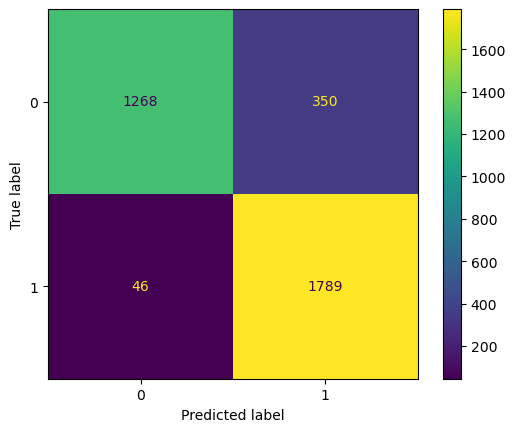

In [18]:
predictions = dt.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [19]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

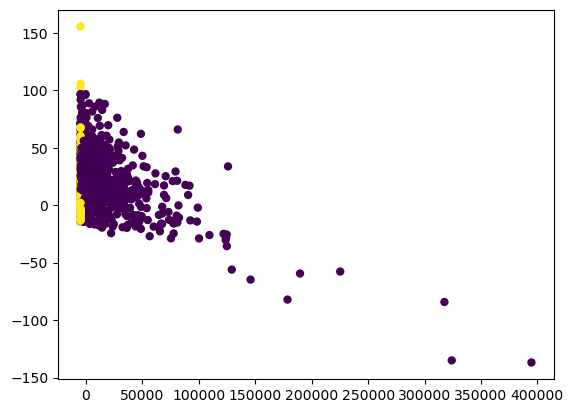

In [20]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

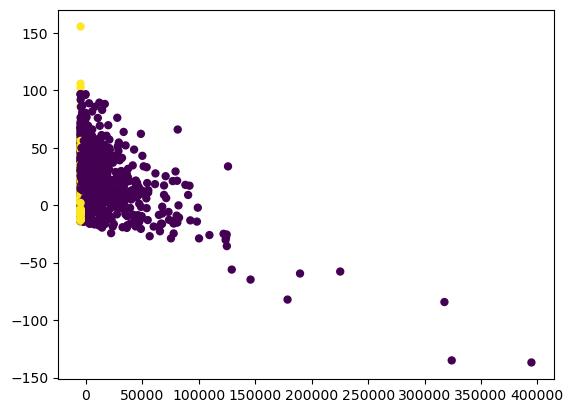

In [21]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save model

In [50]:
with open("models_checkpoints/decision_tree_no_lang.bin", "wb") as f:
    pickle.dump(dt, f)

FileNotFoundError: [Errno 2] No such file or directory: 'models_checkpoints/decision_tree_lang.bin'

## Random forest

In [ ]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)
data = data.join(pd.get_dummies(data["lang"]))
train_set, test_set, train_label, test_label = prepare_data(data)

In [4]:
param_grid = {
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'ccp_alpha': [0.0, 0.1, 0.05, 0.001],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.001],
    'n_estimators': np.arange(80, 150, 10),
}

rf = RandomForestClassifier()

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=4
)

grid.fit(train_set, train_label)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.893 total time=   0.5s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.885 total time=   0.5s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.883 total time=   0.5s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.894 total time=   0.6s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.886 total time=   0.6s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.886 total time=   0.6s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1,

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.845 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.850 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.858 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.848 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.846 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.854 total time=   0.5s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, 

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.849 total time=   0.2s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.851 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.846 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.845 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.843 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.850 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estima

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.897 total time=   0.8s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.891 total time=   0.8s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.889 total time=   0.8s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.895 total time=   0.5s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.886 total time=   0.5s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.888 total time=   0.6s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_es

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.850 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.851 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.855 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.847 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.851 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.857 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, 

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.842 total time=   0.2s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.855 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.849 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.844 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.855 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.850 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimator

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.897 total time=   0.9s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.889 total time=   0.9s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.889 total time=   0.9s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.898 total time=   1.0s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.891 total time=   0.9s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.888 total time=   0.9s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.852 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.851 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.855 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.849 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.851 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.857 total time=   0.5s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, 

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.889 total time=   1.0s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.856 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.849 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.842 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.841 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.845 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.898 total time=   0.7s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.890 total time=   0.7s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.889 total time=   0.7s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.898 total time=   0.8s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.890 total time=   0.8s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.889 total time=   0.8s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.850 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.850 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.854 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.849 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.849 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.858 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.886 total time=   0.8s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.897 total time=   0.9s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.891 total time=   0.9s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.888 total time=   0.9s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.842 total time=   0.2s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.850 total time=   0.2s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimat

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.898 total time=   0.7s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.891 total time=   0.7s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.889 total time=   0.7s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.898 total time=   0.7s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.890 total time=   0.7s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.889 total time=   0.7s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.847 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.849 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.857 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.851 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.850 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.857 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_est

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.850 total time=   0.8s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.855 total time=   0.9s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.850 total time=   0.9s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.849 total time=   0.9s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.842 total time=   0.9s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.850 total time=   0.9s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estim

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.842 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.835 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.850 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.855 total time=   0.7s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.835 total time=   0.7s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.839 total time=   0.7s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=

[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.832 total time=   0.4s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.842 total time=   0.4s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.854 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.850 total time=   0.3s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.850 total time=   0.3s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.789 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_esti

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.850 total time=   0.8s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.855 total time=   0.8s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.835 total time=   0.8s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.849 total time=   0.8s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.855 total time=   0.9s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.849 total time=   0.9s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estim

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.859 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.850 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.841 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.839 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.850 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.850 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0

[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.850 total time=   0.4s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.849 total time=   0.4s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.855 total time=   0.4s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.850 total time=   0.4s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.849 total time=   0.4s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.855 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_esti

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.850 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.855 total time=   0.7s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.850 total time=   0.7s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.849 total time=   0.7s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.855 total time=   0.8s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.836 total time=   0.8s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estim

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.855 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.850 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.850 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.855 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.850 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.850 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001,

[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.850 total time=   0.3s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.850 total time=   0.3s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.855 total time=   0.4s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.850 total time=   0.4s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.850 total time=   0.4s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.855 total time=   0.4s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estim

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.850 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.855 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.835 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.850 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.855 total time=   0.7s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.850 total time=   0.7s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estima

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.855 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.850 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.849 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.855 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.835 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.850 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001,

[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.835 total time=   0.3s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.849 total time=   0.3s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.855 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.850 total time=   0.3s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.840 total time=   0.4s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.855 total time=   0.4s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estim

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.850 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.855 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.850 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.839 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.859 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.850 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimator

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.855 total time=   0.4s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.850 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.849 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.855 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.850 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.850 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001,

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.841 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.841 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.840 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.836 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.839 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.846 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, 

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.839 total time=   0.9s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.839 total time=   0.5s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.847 total time=   0.5s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.842 total time=   0.5s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.839 total time=   0.6s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.842 total time=   0.6s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_e

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.841 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.835 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.841 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.841 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.836 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.841 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.837 total time=   0.2s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.840 total time=   0.2s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.845 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.835 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.839 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.841 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.840 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.843 total time=   0.9s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.849 total time=   0.8s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.841 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.840 total time=   0.5s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.841 total time=   0.5s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.841 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.836 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.840 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.850 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.837 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.840 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.837 total time=   0.2s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.841 total time=   0.2s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.851 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.837 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.840 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.841 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_est

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.843 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.839 total time=   0.8s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.840 total time=   0.8s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.847 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.841 total time=   0.9s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.837 total time=   0.9s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fractio

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.842 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.850 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.840 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.854 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.835 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.839 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.835 total time=   0.9s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.841 total time=   0.9s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.842 total time=   0.2s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.850 total time=   0.2s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.841 total time=   0.2s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.844 total time=   0.2s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_es

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.849 total time=   0.7s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.845 total time=   0.7s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.836 total time=   0.7s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.839 total time=   0.7s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.841 total time=   0.8s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.835 total time=   0.8s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fractio

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.839 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.848 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.838 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.841 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.836 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.842 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.835 total time=   0.8s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.841 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.844 total time=   0.9s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.834 total time=   0.9s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.847 total time=   0.9s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.845 total time=   0.2s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.840 total time=   0.6s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.839 total time=   0.7s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.849 total time=   0.7s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.839 total time=   0.7s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.841 total time=   0.7s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.834 total time=   0.7s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fractio

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.856 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.847 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.847 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.858 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.850 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.850 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_lea

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.898 total time=   0.8s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.889 total time=   0.8s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.888 total time=   0.8s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.897 total time=   0.9s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.890 total time=   0.9s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.889 total time=   0.9s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_lea

[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.890 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.889 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.896 total time=   0.6s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.891 total time=   0.6s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.889 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.897 total time=   0.7s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fr

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.845 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.856 total time=   0.4s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.847 total time=   0.4s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.847 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.854 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.849 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_lea

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.889 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.898 total time=   0.7s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.889 total time=   0.7s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.888 total time=   0.7s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.898 total time=   0.8s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.890 total time=   0.8s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_lea

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.899 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.891 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.888 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.898 total time=   0.6s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.891 total time=   0.6s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.888 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fracti

[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.845 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.848 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.845 total time=   0.4s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.849 total time=   0.4s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.847 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.843 total time=   0.4s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_lea

[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.889 total time=   0.6s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.890 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.898 total time=   0.6s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.890 total time=   0.6s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.888 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.898 total time=   0.7s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.846 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.855 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.847 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.849 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.897 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.891 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fracti

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.855 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.835 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.845 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.840 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.848 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.844 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_lea

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.898 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.889 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.889 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.897 total time=   0.6s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.891 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.888 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0,

[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.851 total time=   0.4s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.850 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.857 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.853 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.849 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.858 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fracti

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.850 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.845 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.838 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.849 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.854 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.834 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.888 total time=   0.8s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.897 total time=   0.9s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.890 total time=   0.9s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.889 total time=   0.9s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.1, 0.05, 0.001],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.001],
                         'n_estimators': array([ 80,  90, 100, 110, 120, 130, 140])},
             scoring='accuracy', verbose=4)

In [5]:
rf = grid.best_estimator_
rf

RandomForestClassifier(min_samples_leaf=3, min_samples_split=3, n_estimators=90)

In [6]:
train_pred = rf.predict(train_set)
test_pred = rf.predict(test_set)

In [7]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9710738671632526
Accuracy test set  0.9009556907037359
Precision train set  0.9725403427176358
Recall train set  0.9710738671632526
F1 score train set  0.9709972213229766
Support train set  (array([0.99971775, 0.94858156]), array([0.93852676, 0.99976641]), array([0.96815635, 0.97350165]), array([3774, 4281]))


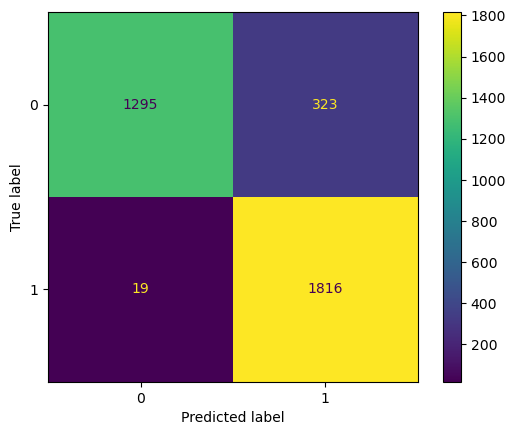

In [8]:
predictions = rf.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [9]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

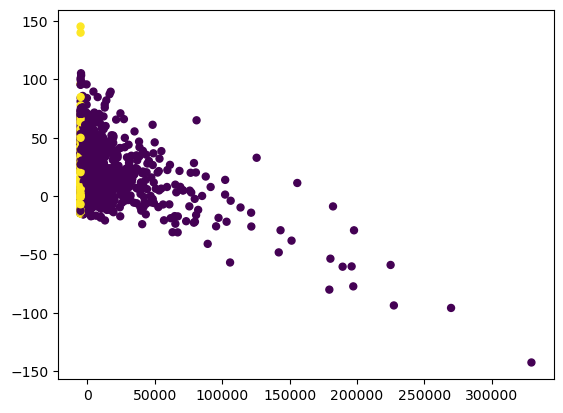

In [10]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

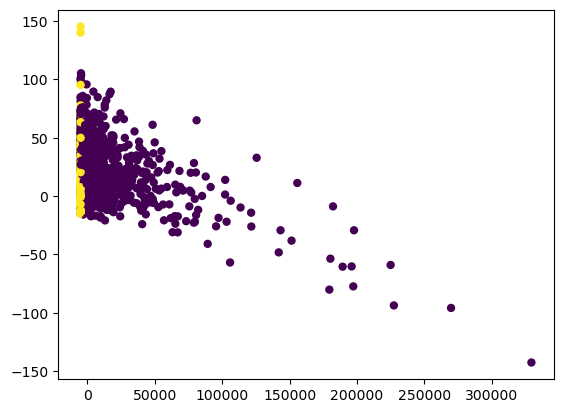

In [11]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save model

In [50]:
with open("models_checkpoints/random_forest_lang.bin", "wb") as f:
    pickle.dump(rf, f)

FileNotFoundError: [Errno 2] No such file or directory: 'models_checkpoints/decision_tree_lang.bin'

### Removed "lang" attribute for classification

In [22]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std']


In [23]:
param_grid = {
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'ccp_alpha': [0.0, 0.1, 0.05, 0.001],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.001],
    'n_estimators': np.arange(80, 150, 10),
}

rf = RandomForestClassifier()

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=4
)

grid.fit(train_set, train_label)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.893 total time=   0.6s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.893 total time=   0.5s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.886 total time=   0.5s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.892 total time=   0.6s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.893 total time=   0.6s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.887 total time=   0.6s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1,

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.857 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.849 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.848 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.855 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.849 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.854 total time=   0.5s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, 

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.835 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.849 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.855 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.841 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.851 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.846 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estima

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.898 total time=   0.9s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.896 total time=   0.9s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.891 total time=   0.8s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.894 total time=   0.5s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.894 total time=   0.5s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.891 total time=   0.5s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_es

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.855 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.850 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.853 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.857 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.850 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.852 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, 

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.836 total time=   0.2s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.847 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.856 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.846 total time=   0.2s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.852 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.854 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimator

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.899 total time=   0.8s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.897 total time=   0.8s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.891 total time=   0.8s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.898 total time=   0.9s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.895 total time=   0.9s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.892 total time=   0.8s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.857 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.851 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.852 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.862 total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.845 total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.856 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.05, 

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.889 total time=   0.9s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.853 total time=   0.2s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.846 total time=   0.2s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.847 total time=   0.2s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.847 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.844 total time=   0.2s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.897 total time=   0.7s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.896 total time=   0.7s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.891 total time=   0.7s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.898 total time=   0.8s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.895 total time=   0.8s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.889 total time=   0.8s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.856 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.850 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.851 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.864 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.850 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.852 total time=   0.4s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_

[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.889 total time=   0.8s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.896 total time=   0.9s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.896 total time=   0.9s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.888 total time=   0.8s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.844 total time=   0.2s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.842 total time=   0.2s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimat

[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.899 total time=   0.7s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.896 total time=   0.7s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.891 total time=   0.7s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.898 total time=   0.7s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.895 total time=   0.8s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.891 total time=   0.7s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=

[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.855 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.849 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.853 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.857 total time=   0.3s
[CV 3/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.847 total time=   0.3s
[CV 1/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.855 total time=   0.3s
[CV 2/3] END ccp_alpha=0.0, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_est

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.834 total time=   0.8s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.850 total time=   0.9s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.855 total time=   0.9s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.848 total time=   0.8s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.850 total time=   0.9s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.855 total time=   0.9s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estim

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.854 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.854 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.848 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.850 total time=   0.7s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.855 total time=   0.7s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.848 total time=   0.7s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=

[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.839 total time=   0.4s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.848 total time=   0.4s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.854 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.855 total time=   0.3s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.841 total time=   0.3s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.850 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_esti

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.848 total time=   0.7s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.850 total time=   0.8s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.855 total time=   0.8s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.848 total time=   0.8s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.850 total time=   0.9s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.840 total time=   0.9s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estim

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.850 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.855 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.838 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.850 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.854 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.848 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0

[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.854 total time=   0.4s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.848 total time=   0.4s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.850 total time=   0.4s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.854 total time=   0.4s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.848 total time=   0.4s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.841 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_esti

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.848 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.850 total time=   0.7s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.842 total time=   0.7s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.848 total time=   0.7s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.850 total time=   0.8s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.854 total time=   0.8s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estim

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.850 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.855 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.848 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.853 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.854 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.842 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001,

[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.854 total time=   0.3s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.848 total time=   0.3s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.850 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.855 total time=   0.4s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.834 total time=   0.3s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.850 total time=   0.4s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estim

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.848 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.850 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.855 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.848 total time=   0.6s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.850 total time=   0.7s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.855 total time=   0.7s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estima

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.850 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.855 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.848 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.799 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.854 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.836 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001,

[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.854 total time=   0.3s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.848 total time=   0.3s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.850 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.854 total time=   0.3s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.848 total time=   0.3s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.850 total time=   0.3s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estim

[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.848 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.850 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.855 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.836 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.850 total time=   0.6s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.854 total time=   0.6s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimator

[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.850 total time=   0.4s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.855 total time=   0.4s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.848 total time=   0.4s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.850 total time=   0.5s
[CV 2/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.855 total time=   0.5s
[CV 3/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.848 total time=   0.5s
[CV 1/3] END ccp_alpha=0.1, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001,

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.841 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.833 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.839 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.840 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.834 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.838 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.1, 

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.835 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.850 total time=   0.5s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.841 total time=   0.5s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.836 total time=   0.5s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.844 total time=   0.6s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.840 total time=   0.6s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_e

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.839 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.842 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.834 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.839 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.854 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.836 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.841 total time=   0.2s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.834 total time=   0.2s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.839 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.839 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.836 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.841 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.833 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.848 total time=   0.9s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.839 total time=   0.9s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.844 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.841 total time=   0.5s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.853 total time=   0.5s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.844 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.841 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.835 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.839 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.846 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.838 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.845 total time=   0.2s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.841 total time=   0.2s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.801 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.841 total time=   0.2s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.832 total time=   0.2s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.841 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_est

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.836 total time=   0.7s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.838 total time=   0.8s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.841 total time=   0.8s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.835 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.838 total time=   0.9s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.841 total time=   0.9s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=3, min_weight_fractio

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.839 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.845 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.835 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.838 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.842 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=110;, score=0.834 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.842 total time=   0.9s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.835 total time=   0.9s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.842 total time=   0.2s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.839 total time=   0.2s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.835 total time=   0.2s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.840 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_es

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.839 total time=   0.7s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.839 total time=   0.8s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.841 total time=   0.8s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.836 total time=   0.7s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.846 total time=   0.8s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.849 total time=   0.9s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=2, min_weight_fractio

[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.839 total time=   0.3s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.847 total time=   0.3s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.834 total time=   0.3s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.843 total time=   0.4s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.842 total time=   0.4s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=100;, score=0.836 total time=   0.4s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.

[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.841 total time=   0.8s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.835 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.844 total time=   0.9s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.842 total time=   0.9s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=140;, score=0.835 total time=   0.8s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=80;, score=0.841 total time=   0.2s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n

[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.833 total time=   0.6s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.843 total time=   0.7s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.840 total time=   0.7s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.837 total time=   0.6s
[CV 1/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.850 total time=   0.7s
[CV 2/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=120;, score=0.843 total time=   0.7s
[CV 3/3] END ccp_alpha=0.05, min_samples_leaf=3, min_samples_split=4, min_weight_fractio

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.850 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.857 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.845 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.851 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.855 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.05, n_estimators=90;, score=0.847 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_lea

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.898 total time=   0.8s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.896 total time=   0.8s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.893 total time=   0.8s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.899 total time=   0.9s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.895 total time=   0.9s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=130;, score=0.893 total time=   0.8s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_lea

[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.895 total time=   0.6s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.892 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.899 total time=   0.7s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.895 total time=   0.7s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=100;, score=0.892 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.001, n_estimators=110;, score=0.898 total time=   0.7s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=3, min_weight_fr

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.844 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.848 total time=   0.4s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.850 total time=   0.4s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.840 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.855 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=80;, score=0.858 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_lea

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.891 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.899 total time=   0.7s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.895 total time=   0.7s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.893 total time=   0.7s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.900 total time=   0.8s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=120;, score=0.895 total time=   0.8s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_lea

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.899 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.896 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.892 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.899 total time=   0.6s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.894 total time=   0.6s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=90;, score=0.892 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fracti

[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.851 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.836 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.848 total time=   0.4s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.843 total time=   0.4s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=130;, score=0.838 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.1, n_estimators=140;, score=0.851 total time=   0.4s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_lea

[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.895 total time=   0.6s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.892 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.899 total time=   0.7s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.895 total time=   0.7s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.893 total time=   0.6s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=110;, score=0.899 total time=   0.7s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.850 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.849 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.855 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.845 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.898 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=80;, score=0.896 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=4, min_weight_fracti

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.853 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.845 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.842 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.848 total time=   0.4s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.842 total time=   0.4s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=120;, score=0.834 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=2, min_weight_fraction_lea

[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.899 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.894 total time=   0.5s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=80;, score=0.892 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.899 total time=   0.6s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.894 total time=   0.6s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=90;, score=0.892 total time=   0.5s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.0,

[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.856 total time=   0.4s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=120;, score=0.849 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.851 total time=   0.4s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.857 total time=   0.4s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=130;, score=0.843 total time=   0.4s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fraction_leaf=0.05, n_estimators=140;, score=0.848 total time=   0.5s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3, min_weight_fracti

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=90;, score=0.838 total time=   0.2s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.852 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.854 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=100;, score=0.847 total time=   0.3s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.851 total time=   0.3s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.1, n_estimators=110;, score=0.844 total time=   0.3s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf

[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=130;, score=0.892 total time=   0.8s
[CV 1/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.898 total time=   0.9s
[CV 2/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.894 total time=   0.9s
[CV 3/3] END ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4, min_weight_fraction_leaf=0.001, n_estimators=140;, score=0.893 total time=   0.9s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.1, 0.05, 0.001],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.001],
                         'n_estimators': array([ 80,  90, 100, 110, 120, 130, 140])},
             scoring='accuracy', verbose=4)

In [24]:
rf = grid.best_estimator_
rf

RandomForestClassifier(ccp_alpha=0.001, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=130)

In [25]:
train_pred = rf.predict(train_set)
test_pred = rf.predict(test_set)

In [26]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8985723153320919
Accuracy test set  0.8960324355632783
Precision train set  0.9142203238328424
Recall train set  0.8985723153320919
F1 score train set  0.8968832221186307
Support train set  (array([0.99764389, 0.84067663]), array([0.78537361, 0.99836487]), array([0.87887324, 0.91276028]), array([3774, 4281]))


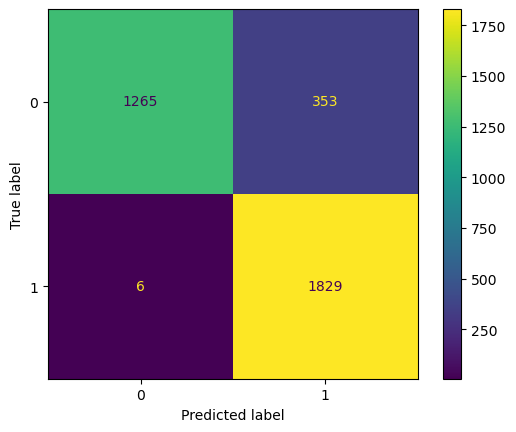

In [27]:
predictions = rf.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [28]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

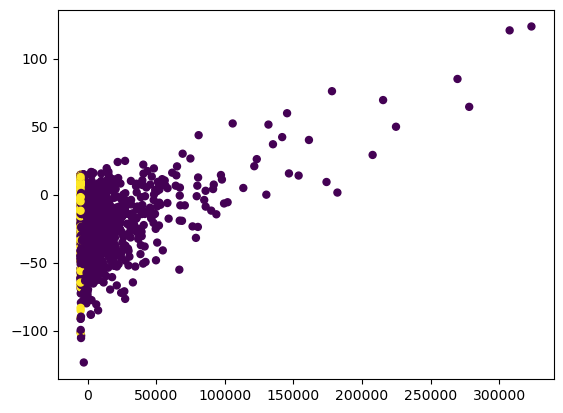

In [29]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

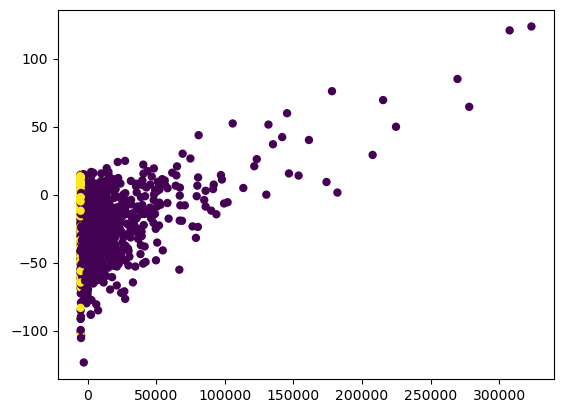

In [30]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save model

In [50]:
with open("models_checkpoints/random_forest_no_lang.bin", "wb") as f:
    pickle.dump(rf, f)

FileNotFoundError: [Errno 2] No such file or directory: 'models_checkpoints/decision_tree_lang.bin'

### Random Hyperparameter Grid Search (FORSE RIMUOVERE!!!)

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=4,
    random_state=42,
    n_jobs = -1
)

rf_random.fit(train_set, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (rf_random.best_params_, rf_random.best_score_)
)



In [ ]:
rf = rf_random.best_estimator_

In [ ]:
train_pred = rf.predict(train_set)
test_pred = rf.predict(test_set)

In [ ]:
# cross validation
scores = cross_validate(rf, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

In [ ]:
predictions = rf.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [ ]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

In [ ]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

In [ ]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save Model

In [ ]:
with open("models_checkpoints/random_forest_2_no_lang.bin", "wb") as f:
    pickle.dump(dt, f)